In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import scipy.spatial.distance as ssd
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import scipy.interpolate
import scipy.cluster.hierarchy as shc

os.chdir(r"C:\Users\A4023862\Documents\GitHub")
from path_segmentation.functions import *
import warnings
warnings.filterwarnings("ignore")

def clean_cols(df):
    import re
    
    cols=list(df.columns.values)
    
    # Lowercase everything
    cols=list(map(lambda x: x.lower(), cols))
    
    # Remove special characters 
    cols = [re.sub(r'[^a-zA-Z0-9]','_',string) for string in cols]
    
    # Rename colums
    df.columns = cols

    return df

# Read in Data

In [49]:
df=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df.csv")

In [50]:
cols=['interaction_id', 'id', 'rec_date', 'month_id', 'flag', 'value', 'dob', 'ethnicity', 'race', 'state', 'year', 'age', 'row', 'max','age_grp']
df.columns = cols
df.head()

,interaction_id,id,rec_date,month_id,flag,value,dob,ethnicity,race,state,year,age,row,max,age_grp
0,614619_2020-05-26_0035_37,616541,2020-05-26 18:30:12,202005,bmi,45.0,1974,NaN,AFRICAN AMERICAN,NY,2020,46,35,37,46-50
1,614619_2020-05-26_0036_37,616541,2020-05-26 18:56:49,202005,hyst_oophorectomy,1.0,1974,NaN,AFRICAN AMERICAN,NY,2020,46,36,37,46-50
2,614619_2020-05-26_0037_37,616541,2020-05-26 18:56:49,202005,hysterectomy,1.0,1974,NaN,AFRICAN AMERICAN,NY,2020,46,37,37,46-50
3,621586_2014-02-21_0006_40,623508,2014-02-21 05:00:00,201402,headache_migraine,1.0,1958,NaN,UNKNOWN,NY,2014,56,6,40,56-60
4,621586_2014-02-21_0007_40,623508,2014-02-21 05:00:00,201402,headache_migraine_freq,2.0,1958,NaN,UNKNOWN,NY,2014,56,7,40,56-60


# Data Prep

## Pivot Table

In [51]:
values='value'
index=['interaction_id', 'id', 'rec_date', 'age', 'age_grp', 'race', 'state']
columns='flag'
aggfunc=max

df_pivot = data_pivot(df,values,index,columns,aggfunc)
df_pivot.head()

MemoryError: Unable to allocate 880. MiB for an array with shape (57, 2022677) and data type int64

In [52]:
q=df_pivot[df_pivot['last_period']==1]
q=q[['id','rec_date']]
q=q.groupby(['id']).agg(['min']).reset_index()
q.columns = ['id', 'min_last_period_date']

w = pd.merge(df_pivot, q, how="left", on="id")
w['post_meno']=np.where(w['rec_date']>= w['min_last_period_date'],1,0)
w.head()

,interaction_id,id,rec_date,age,age_grp,race,state,alcohol_consumption,amenorrhea,anxiety,...,uni_oophorectomy,urge_incontinence,uti,vaginal_dryness,vaginal_dryness_freq,vaginal_dryness_rx,vaginal_dryness_sev,weight_gain,min_last_period_date,post_meno
0,10000477_2005-06-27_0001_41,10002399,2005-06-27 00:00:00,53,51-55,CAUCASIAN,NY,0,0,0,...,0,0,0,0,0,0,0,0,2005-06-27 00:00:00,1
1,10000477_2006-06-27_0002_41,10002399,2006-06-27 04:00:00,53,51-55,CAUCASIAN,NY,0,0,0,...,0,0,0,0,0,0,0,0,2005-06-27 00:00:00,1
2,10000477_2006-06-27_0003_41,10002399,2006-06-27 04:00:00,53,51-55,CAUCASIAN,NY,0,0,0,...,0,0,0,0,0,0,0,0,2005-06-27 00:00:00,1
3,10000547_2014-03-22_0004_20,10002469,2014-03-22 09:17:21,58,56-60,UNKNOWN,NY,0,0,0,...,0,0,0,0,0,0,0,0,NaN,0
4,10000547_2014-03-22_0005_20,10002469,2014-03-22 09:17:21,58,56-60,UNKNOWN,NY,0,0,0,...,0,0,0,0,0,0,0,0,NaN,0


## Aggregate to Quarter

In [53]:
# Aggregate to quarter
w['quarter'] = pd.PeriodIndex(w.rec_date, freq='Q').to_timestamp()
# Write to csv
w.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter.csv")

# Max to the quarter
q=w.groupby(['id', 'quarter']).max().reset_index()
q.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg.csv")

## Make there is certain number of interactions and BMI records

In [54]:
w=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg.csv")
w['max']=w['id'].groupby(w['id']).transform('count')

# Get list of ids that meet threshold of interactions
w.groupby(['max'])['id'].nunique()
pts_int_thresh=w[w['max']>10]
pts_int_thresh=pts_int_thresh[pts_int_thresh['max']<20]
pts_int_thresh_list=set(pts_int_thresh['id'])
pts_int_thresh.groupby(['max'])['id'].nunique()
print(pts_int_thresh.shape)
print(len(pts_int_thresh_list))

# Make there is certain number of interactions
w.columns
e=w[w['id'].isin(pts_int_thresh_list)]
print('Pts before filter ', w['id'].nunique())
print('Pts that meet interaction threshold ', len(pts_int_thresh_list))
print('Pts after filter ', e['id'].nunique())

e.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg2.csv")


(196162, 69)
14573
Pts before filter  96929
Pts that meet interaction threshold  14573
Pts after filter  14573


## BMI Cleanup

In [64]:
# Remove BMI Outliers
w=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg2.csv")

#Replace any BMI values below 15 and above 50 with 0
w1=w[(w['bmi']<15) | (w['bmi']>50)]
w2=w[~w['interaction_id'].isin(w1['interaction_id'])]
w1['bmi']=0

# Add bmi data back
w3 = pd.concat([w1, w2])

print(w.shape[0], ' interactions in original df')
print(w3.shape[0], ' interactions in cleansed df')
print('BMI Range (original): ', max(w['bmi']),' -', min(w['bmi']))
print('BMI Range (cleansed): ', max(w3['bmi']),' -', min(w3['bmi']))

w3.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg2_clean.csv")

196162  interactions in original df
196162  interactions in cleansed df
BMI Range (original):  12245.0  - 0.0
BMI Range (cleansed):  49.99  - 0.0


In [65]:
# Make sure there are atleast 2 BMI records
w=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg2_clean.csv")

#Replace any BMI values below 15 with 0


# Get count of records for each id with bmi values that aren't 0
yes_bmi=w[w['bmi']>0].groupby('id')['bmi'].count().reset_index()

# Get ids that have mort than 2 records
yes_bmi=yes_bmi[yes_bmi['bmi']>2]
yes_bmi.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\crap.csv")

# Filter the dataset to only include these ids
q=w[w['id'].isin(yes_bmi['id'])]
print('# of patients with more than 1 good BMI record',len(yes_bmi['id']))
print('# of patients to keep',q['id'].nunique())

q.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg3.csv")


# of patients with more than 1 good BMI record 14465
# of patients to keep 14465


## Interpolate BMI

In [66]:
#https://kanoki.org/2020/04/14/resample-and-interpolate-time-series-data/
q=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg3.csv")

q[ 'quarter' ] = pd.to_datetime(q['quarter'])

# Replace 0 with NAN
q.replace(0, np.nan, inplace=True)

def interpolate_bmi(df):
    # Interpolate BMI
    q1=df[['quarter', 'bmi']].set_index('quarter').resample('Q', label='left').mean().interpolate('spline', order=1)
    
    # Replace BMI with nearest when unable to interpolate
    mask = np.isnan(q1['bmi'])
    q1['bmi'][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), q1['bmi'][~mask])

    # Reset Index
    q1=q1.reset_index()
    
    # Fix date
    q1['quarter']=pd.DatetimeIndex(q1['quarter']) + pd.DateOffset(1)
    
    # Merge back with dataset
    del(df['bmi'])
    q2=df.merge(q1, how='left', on='quarter')
    return q2

q1=q.groupby('id').apply(lambda x: interpolate_bmi(x))

q1.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg3_bmi.csv")

## Select variables to keep

In [69]:
e.columns

Index(['id', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'id.1', 'quarter', 'interaction_id', 'rec_date',
       'age', 'age_grp', 'race', 'state', 'alcohol_consumption', 'amenorrhea',
       'anxiety', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other',
       'bc_patch', 'bi_oophorectomy', 'birth_control', 'bloating',
       'breast_cancer', 'cancer', 'dec_libido', 'depression', 'dizziness',
       'dry_skin', 'dyspareunia', 'endometrial ablation', 'fatigue',
       'hair_loss', 'headache_migraine', 'headache_migraine_freq',
       'headache_migraine_rx', 'hot_flash', 'hot_flash_freq', 'hot_flash_rx',
       'hot_flash_sev', 'hrt', 'hyst_oophorectomy', 'hysterectomy',
       'incontinence', 'irritability', 'last_period', 'memory_lapse',
       'menopause', 'menstrual_changes', 'night_sweats', 'night_sweats_freq',
       'night_sweats_rx', 'night_sweats_sev', 'oab_incontinence',
       'oligomenorrhea', 'osteoporosis', 'sexual_dysfunction'

In [159]:
e=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg3_bmi.csv")
e=e.fillna(0)
symp_list=list(e.columns)
unwanted = {'race','min_last_period_date', 'quarter', 
            'Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 
            'Unnamed: 0.1.1.1', 'id.1',
            'rec_date', 'age_grp', 'state',
           'breast_cancer','cancer', 'last_period', 'max'}
symp_list = [e for e in symp_list if e not in unwanted]

# symp_list=['id', 'age',
#        'alcohol_consumption', 'amenorrhea', 'bc_implant',
#        'bc_injection', 'bc_oral', 'bc_other', 'bi_oophorectomy',
#        'birth_control',
#        'dec_libido','dry_skin', 'dyspareunia',
#        'fatigue', 'hair_loss', 'headache_migraine',
#         'hot_flash','hot_flash_rx',
#        'hyst_oophorectomy', 'hysterectomy',
#        'last_period', 'memory_lapse', 'menopause',
#        'night_sweats', 'night_sweats_rx','oab_incontinence', 'sleep_disturbance', 'smoker',
#        'stress_incontinence', 'uni_oophorectomy', 'urge_incontinence', 'uti',
#        'vaginal_dryness', 'weight_gain',
#        'post_meno']

train=e[symp_list]

In [71]:
train.columns

Index(['id', 'interaction_id', 'age', 'alcohol_consumption', 'amenorrhea',
       'anxiety', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other',
       'bc_patch', 'bi_oophorectomy', 'birth_control', 'bloating',
       'dec_libido', 'depression', 'dizziness', 'dry_skin', 'dyspareunia',
       'endometrial ablation', 'fatigue', 'hair_loss', 'headache_migraine',
       'headache_migraine_freq', 'headache_migraine_rx', 'hot_flash',
       'hot_flash_freq', 'hot_flash_rx', 'hot_flash_sev', 'hrt',
       'hyst_oophorectomy', 'hysterectomy', 'incontinence', 'irritability',
       'memory_lapse', 'menopause', 'menstrual_changes', 'night_sweats',
       'night_sweats_freq', 'night_sweats_rx', 'night_sweats_sev',
       'oab_incontinence', 'oligomenorrhea', 'osteoporosis',
       'sexual_dysfunction', 'sleep_disturbance', 'smoker',
       'stress_incontinence', 'uni_oophorectomy', 'urge_incontinence', 'uti',
       'vaginal_dryness', 'vaginal_dryness_freq', 'vaginal_dryness_rx',
       'vagina

In [160]:
# Filter patients with surgical menopause, cancer
w1=e[e['bi_oophorectomy']==1]
w2=e[e['hysterectomy']==1]
w3=e[e['uni_oophorectomy']==1]
w4=e[(e['cancer']==1) | (e['breast_cancer']==1)]
w5 = pd.concat([w1,w2,w3, w4],ignore_index=True)

train=train[~train.id.isin(w5['id'])]

# Reduce sparsity in data
train['sym_count']=train.drop(['id','age','bmi'],axis=1).sum(1)
train = train[train['sym_count']>3]

#seperate pre and post meno observations
train1=train[train['post_meno']==0].reset_index(drop=True)
train2=train[train['post_meno']==1].reset_index(drop=True)

print('# of patients with ooph, hyst or cancer: %d' % w5.id.nunique())
print('# of patients overall: %d' % e.id.nunique())
print('# of patients final: %d' % train.id.nunique())
print('# of patients pre: %d' % train1.id.nunique())
print('# of patients post: %d' % train2.id.nunique())

# of patients with ooph, hyst or cancer: 5192
# of patients overall: 14465
# of patients final: 5972
# of patients pre: 4185
# of patients post: 2164


In [93]:
find_nulls(train)

No Nulls found


In [94]:
#sample 500 patients
train1_sampled = sample(train1,500,'id')
train2_sampled = sample(train2,500,'id')

Sample Count of patients: 500
Sample Count of patients: 500


# Method: Current

## Dimensionality Reduction/Similarity - Jaccard Distance

In [103]:
# Pre-Meno
trainer1 = train1_sampled.reset_index(drop=True).copy()
trainer_reduced1 = remove_insig_features(trainer1,0.9,['interaction_id', 'id','age','post_meno','age_group', 'sym_count'])

drop_col_list = ['interaction_id','id','post_meno', 'sym_count']
jaccard_df1 = jaccard_dist(trainer_reduced1,drop_col_list)

# Post-Meno
trainer2 = train2_sampled.reset_index(drop=True).copy()
trainer_reduced2 = remove_insig_features(trainer2,0.9,['interaction_id','id','age','post_meno','age_group', 'sym_count'])

drop_col_list = ['interaction_id','id','post_meno', 'sym_count']
jaccard_df2 = jaccard_dist(trainer_reduced2,drop_col_list)

print('# of patients pre: %d' % train1_sampled.id.nunique())
print('# of patients post: %d' % train2_sampled.id.nunique())
print('Jaccard Pre-Meno shape: ', jaccard_df1.shape)
print('Jaccard Post-Meno shape: ', jaccard_df2.shape)


0.9 % data count = 12
Significant Columns are: interaction_id id age post_meno age_group sym_count alcohol_consumption anxiety bc_implant bc_injection bc_oral birth_control bloating depression dizziness dry_skin fatigue hair_loss headache_migraine headache_migraine_freq headache_migraine_rx hot_flash hot_flash_freq hot_flash_rx hot_flash_sev incontinence memory_lapse menopause menstrual_changes night_sweats night_sweats_freq night_sweats_sev oab_incontinence osteoporosis sexual_dysfunction sleep_disturbance stress_incontinence urge_incontinence uti vaginal_dryness vaginal_dryness_freq vaginal_dryness_rx vaginal_dryness_sev weight_gain
Data Dimensions: (1403, 39)
Jaccard Dataframe Dimensions: (1403, 1403)
0.9 % data count = 14
Significant Columns are: interaction_id id age post_meno age_group sym_count alcohol_consumption anxiety bc_injection bc_oral birth_control bloating dec_libido depression dizziness dry_skin fatigue hair_loss headache_migraine headache_migraine_freq headache_migrai

In [104]:
def jaccard_dist(df,drop_col_list):
    df = df.drop(drop_col_list,axis = 1).copy()
    df = df.astype('str')
    print("Data Dimensions:",df.shape)
    jaccard_df = ssd.pdist(df, metric='jaccard')
    jaccard_df = pd.DataFrame(ssd.squareform(jaccard_df))
    print("Jaccard Dataframe Dimensions:",jaccard_df.shape)
    return jaccard_df

drop_col_list = ['interaction_id','id','post_meno']
q = trainer_reduced1.drop(drop_col_list,axis = 1).copy()
q = q.astype('str')
q = ssd.pdist(q, metric='jaccard')
# q = pd.DataFrame(ssd.squareform(q))
q.shape

(983503,)

## State Identification - Agglomerative Clustering

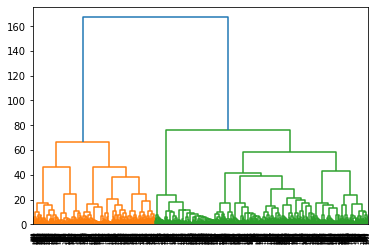

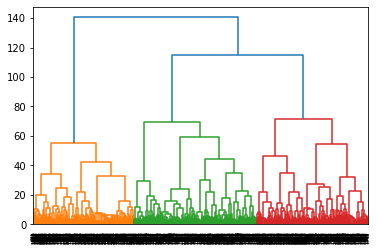

In [105]:
#Plotting Dendograms
plt.figure()
Dendrogram = shc.dendrogram((shc.linkage(jaccard_df1, method ='ward')))
plt.show()

plt.figure()
Dendrogram = shc.dendrogram((shc.linkage(jaccard_df2, method ='ward')))
plt.show()

In [102]:
# Pre-Meno
n_clusters = 20
linkage = 'ward'
trainer_result1,trainer_result_reduced1,labels1 = cluster_agg(jaccard_df1,trainer_reduced1,trainer1,n_clusters,linkage)

# Post-Meno
n_clusters = 20
linkage = 'ward'
trainer_result2,trainer_result_reduced2,labels2 = cluster_agg(jaccard_df2,trainer_reduced2,trainer2,n_clusters,linkage)

Cluster counts:
 15    170
8     117
0     106
2     103
1      91
5      87
3      87
7      75
4      73
13     68
12     65
14     64
10     54
9      51
6      50
17     34
11     32
18     30
16     26
19     20
Name: cluster, dtype: int64
Silhouette Score: 0.08019869759885848
Cluster counts:
 4     170
10    137
0     117
1     103
9     100
14     99
5      93
2      93
12     91
6      88
7      81
3      75
11     72
16     65
13     60
8      51
15     49
19     38
18     35
17     32
Name: cluster, dtype: int64
Silhouette Score: 0.11464607291715122


In [78]:
trainer_result1.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\pre_meno_cluster.csv")
trainer_result2.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\post_meno_cluster.csv")

In [109]:
cont_cols=['age', 'bmi','headache_migraine_freq', 'headache_migraine_rx', 
'hot_flash_freq', 'hot_flash_rx', 'hot_flash_sev',
'night_sweats_freq', 'night_sweats_rx', 'night_sweats_sev',
'vaginal_dryness_freq', 'vaginal_dryness_rx','vaginal_dryness_sev']

categorical_cols=['alcohol_consumption', 'amenorrhea',
       'anxiety', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other',
       'bc_patch', 'bi_oophorectomy', 'birth_control', 'bloating',
       'dec_libido', 'depression', 'dizziness', 'dry_skin', 'dyspareunia',
       'endometrial ablation', 'fatigue', 'hair_loss', 'headache_migraine', 'hot_flash', 'hrt',
       'hyst_oophorectomy', 'hysterectomy', 'incontinence', 'irritability',
       'memory_lapse', 'menopause', 'menstrual_changes', 'night_sweats',
       'oab_incontinence', 'oligomenorrhea', 'osteoporosis',
       'sexual_dysfunction', 'sleep_disturbance', 'smoker',
       'stress_incontinence', 'uni_oophorectomy', 'urge_incontinence', 'uti',
       'vaginal_dryness', 'weight_gain', 'post_meno']

def analyze_clusters(df, cont_cols_list, categorical_cols_list, cluster_name):
    cluster_analysis_df = df.groupby([cluster_name]).agg(pts=('id','count'))
    
    for i in range(0, len(cont_cols_list)):
        df_q=df.groupby([cluster_name]).agg({cont_cols_list[i]:'mean'})
        cluster_analysis_df=cluster_analysis_df.merge(df_q, how='left', on=cluster_name)
        cluster_analysis_df[cont_cols_list[i]]=np.round(cluster_analysis_df[cont_cols_list[i]],2)
    
    for i in range(0, len(categorical_cols_list)):
        df_q=df.groupby([cluster_name]).agg({categorical_cols_list[i]:'sum'})
        cluster_analysis_df=cluster_analysis_df.merge(df_q, how='left', on=cluster_name)
        cluster_analysis_df[categorical_cols_list[i]]=np.round((cluster_analysis_df[categorical_cols_list[i]]/cluster_analysis_df['pts'])*100,2)
    
    return cluster_analysis_df

# Pre-Meno
cluster_analysis_df1=analyze_clusters(trainer_result1, cont_cols, categorical_cols, 'cluster')

cluster_analysis_df1['cluster'] = cluster_analysis_df1.index
cluster_analysis_df1['cluster'] = cluster_analysis_df1['cluster'].astype(str) + 'A'

# Post-Meno
cluster_analysis_df2=analyze_clusters(trainer_result2, cont_cols, categorical_cols, 'cluster')

cluster_analysis_df2['cluster'] = cluster_analysis_df2.index
cluster_analysis_df2['cluster'] = cluster_analysis_df2['cluster'].astype(str) + 'B'

# Stack Pre and Post Meno tables
cluster_analysis_df_agg = pd.concat([cluster_analysis_df1, cluster_analysis_df2], ignore_index=True)
cluster_analysis_df_agg
cluster_analysis_df_agg.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\cluster_summaries.csv")

## State Prediction

In [143]:
# PRE-MENO

# Training
label = 'cluster'
train_split = 0.8
drop_col_list = ['interaction_id', 'post_meno']
dummy_cols=[]

test_data,train_col_list,model = log_reg_train(trainer_result_reduced1,label,train_split,drop_col_list,'id', dummy_cols)

# Feature Importance
importance = model.coef_[0]
features=list(trainer_result_reduced1.columns)
features = [e for e in features if e not in ('interaction_id', 'cluster', 'post_meno')]

for i,v in enumerate(importance):
    print(features[i], 'Feature: %0d, Score: %.5f' % (i,v))


# Testing
train_col_list = train_col_list
model = model
test_or_pred = 0
log_reg_test(test_data,label,train_col_list,model,test_or_pred, 'id', dummy_cols)

import pickle
pickle.dump(model, open('C:/Users/A4023862/Documents/GitHub/output/pathseg_pre_meno.pickle', 'wb'))

Total Patients: 500
Patients in Training Set: 400
Patients in Test Set: 100
Training Data with dummies shape: (4688, 26)
No. of Clusters: 15
Training Logistic Regression Model...
Accuracy of logistic regression classifier on train set: 70.03%
id Feature: 0, Score: -0.00004
age Feature: 1, Score: -0.05066
alcohol_consumption Feature: 2, Score: 1.32928
anxiety Feature: 3, Score: 0.51864
bc_oral Feature: 4, Score: -1.40331
birth_control Feature: 5, Score: -0.96764
bloating Feature: 6, Score: 1.63410
depression Feature: 7, Score: 0.66427
dizziness Feature: 8, Score: 0.75711
dry_skin Feature: 9, Score: 0.64810
fatigue Feature: 10, Score: 1.00729
hair_loss Feature: 11, Score: 0.74358
headache_migraine Feature: 12, Score: 4.58010
headache_migraine_freq Feature: 13, Score: 0.30644
headache_migraine_rx Feature: 14, Score: 1.53642
incontinence Feature: 15, Score: 1.05359
menopause Feature: 16, Score: 1.01315
menstrual_changes Feature: 17, Score: 0.59341
oab_incontinence Feature: 18, Score: 0.880

In [142]:
# POST-MENO

# Training
label = 'cluster'
train_split = 0.8
drop_col_list = ['interaction_id', 'post_meno']
dummy_cols=[]

test_data,train_col_list,model = log_reg_train(trainer_result_reduced2,label,train_split,drop_col_list,'id', dummy_cols)

# Feature Importance
importance = model.coef_[0]
features=list(trainer_result_reduced2.columns)
features = [e for e in features if e not in ('interaction_id', 'cluster', 'post_meno')]

for i,v in enumerate(importance):
    print(features[i], 'Feature: %0d, Score: %.5f' % (i,v))

# Testing
train_col_list = train_col_list
model = model
test_or_pred = 0
log_reg_test(test_data,label,train_col_list,model,test_or_pred, 'id', dummy_cols)

import pickle
pickle.dump(model, open('C:/Users/A4023862/Documents/GitHub/output/pathseg_post_meno.pickle', 'wb'))

Total Patients: 500
Patients in Training Set: 400
Patients in Test Set: 100
Training Data with dummies shape: (4364, 35)
No. of Clusters: 15
Training Logistic Regression Model...
Accuracy of logistic regression classifier on train set: 66.84%
id Feature: 0, Score: 0.00004
age Feature: 1, Score: -0.67141
alcohol_consumption Feature: 2, Score: 0.09486
anxiety Feature: 3, Score: -0.05443
bc_oral Feature: 4, Score: 3.02584
birth_control Feature: 5, Score: 2.97235
bloating Feature: 6, Score: 0.22998
depression Feature: 7, Score: 0.35378
dizziness Feature: 8, Score: 0.10736
dry_skin Feature: 9, Score: 1.42306
fatigue Feature: 10, Score: 0.53599
hair_loss Feature: 11, Score: -0.45185
headache_migraine Feature: 12, Score: 6.20350
headache_migraine_freq Feature: 13, Score: 1.39065
headache_migraine_rx Feature: 14, Score: 1.55571
hot_flash Feature: 15, Score: 1.45119
hot_flash_freq Feature: 16, Score: 1.28420
hot_flash_rx Feature: 17, Score: -0.01733
hot_flash_sev Feature: 18, Score: 1.67142
hrt

In [139]:
len(trainer_result_reduced2.columns)

36

# Method - ACTPC (Full Time Series)

In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
# Reduce sparsity in data
train1['sym_count']=train1.drop(['id','age','bmi'],axis=1).sum(1)
train1 = train1[train1['sym_count']>3]

# Get count of time points and features
t_series=train1.groupby('id')['id'].transform('count').max()
symp_list=list(train1.columns)
features = [e for e in symp_list if e not in ('id', 'interaction_id', 'age', 'post_meno', 'sym_count')]
print (t_series, " Time Points")
print (len(features), " Features")

18  Time Points
54  Features


In [107]:
t_series = t_series
features_n = len(features)
data_lst = []
sz = t_series*features_n

for ptnt in train1.id.unique():
    tmp = np.array(train1[train1['id']==ptnt].drop(['id', 'interaction_id', 'age', 'post_meno', 'sym_count'],axis=1))
    tmp_0 = np.zeros(sz)
    tmp_0[:tmp.size] = tmp.reshape(tmp.size,)
    tmp = tmp_0.reshape(t_series,features_n).astype(int)
    data_lst.append(tmp)
data_lst = np.array(data_lst).copy()

patients = data_lst.shape[0]
t_series = data_lst.shape[1]
features = data_lst.shape[2]

# Define sequence
sequence = np.array(data_lst).reshape((patients, t_series, features))

print("Patients: ", patients)
print("TS: ", t_series)
print("Features: ", features)

Patients:  4185
TS:  18
Features:  54


In [40]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(t_series, features),return_sequences=False, name = 'Encoder_1'))
#model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(RepeatVector(t_series, name = 'Repeater_bridge'))
#model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True, name = 'Decoder_1'))
model.add(TimeDistributed(Dense(features),name = 'Time_Distributed'))
model.compile(optimizer='adam', loss='mse')
model.build()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (LSTM)            (None, 50)                21000     
                                                                 
 Repeater_bridge (RepeatVect  (None, 18, 50)           0         
 or)                                                             
                                                                 
 Decoder_1 (LSTM)            (None, 18, 50)            20200     
                                                                 
 Time_Distributed (TimeDistr  (None, 18, 54)           2754      
 ibuted)                                                         
                                                                 
Total params: 43,954
Trainable params: 43,954
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Fit model
history = model.fit(sequence, sequence, epochs=10)

# Training Loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/10
131/131 [==============================] - 3s 10ms/step - loss: 2.0716
Epoch 2/10
131/131 [==============================] - 1s 10ms/step - loss: 0.5129
Epoch 3/10
131/131 [==============================] - 1s 11ms/step - loss: 0.3073
Epoch 4/10
131/131 [==============================] - 1s 10ms/step - loss: 0.2666
Epoch 5/10
131/131 [==============================] - 1s 11ms/step - loss: 0.2258
Epoch 6/10
131/131 [==============================] - 1s 11ms/step - loss: 0.1713
Epoch 7/10
131/131 [==============================] - 1s 11ms/step - loss: 0.1679
Epoch 8/10
131/131 [==============================] - 1s 10ms/step - loss: 0.1432
Epoch 9/10
131/131 [==============================] - 2s 13ms/step - loss: 0.1240
Epoch 10/10
131/131 [==============================] - 2s 14ms/step - loss: 0.1470


In [43]:
# demonstrate recreation
yhat = model.predict(sequence)
print(yhat[0,0,:])

[ 1.73167706e-01  1.51996925e-01  2.80117512e-01 -2.15148460e-03
  5.61530888e-03  1.34382248e-01 -2.47498322e-02 -1.05885625e-01
  2.50812750e-02  2.02160001e-01 -7.94345737e-02  2.90865488e-02
  1.75766528e-01  1.29847348e-01  8.64997283e-02 -3.28063220e-02
  4.45024632e-02  1.87360555e-01  2.84272097e-02  6.59531593e-01
  2.24713159e+00  4.54769731e-01  5.46210855e-02  5.19667268e-02
  5.60018159e-02  7.03687267e-03 -1.46535829e-01 -4.11908627e-02
  1.50736630e-01  8.17355588e-02 -5.54187596e-03  6.52163252e-02
  1.41726106e-01 -4.87744324e-02  3.49020176e-02  8.42813775e-03
  9.99183804e-02 -7.66420551e-03  8.81197155e-02  5.10019138e-02
  1.97959691e-01 -3.95667627e-02  1.19630650e-01  6.20808899e-02
  2.10889131e-01  6.41318113e-02  3.23431380e-02  4.38534319e-02
 -1.13565847e-03  1.03686847e-01 -8.78922343e-02 -7.54642487e-03
  7.54960775e-02  2.99651413e+01]


In [44]:
encoder_layer = Model(inputs=model.inputs, outputs=model.layers[0].output)
encoded_features = np.array(encoder_layer.predict(sequence))

# Convert array of encoded features into dataframe
df_2 = pd.DataFrame(encoded_features)
df_2.head()

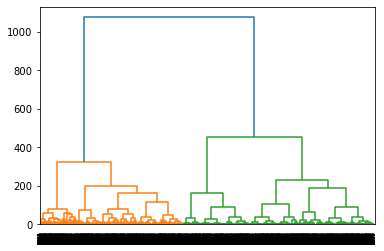

In [46]:
#Plotting Dendograms
import scipy.cluster.hierarchy as shc
plt.figure()
Dendrogram = shc.dendrogram((shc.linkage(df_2, method ='ward')))
plt.show()

In [72]:
# Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

clu_model = AgglomerativeClustering(n_clusters = 4,linkage='ward')
labels = clu_model.fit_predict(df_2)


# How distributed are the labels
import collections
print(collections.Counter(labels))

# Clustering Metrics
mtrcs = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock']

for i in mtrcs:
    print(i,"- Silhouette Score:",metrics.silhouette_score(df_2,labels,metric = i))


Counter({0: 1561, 1: 1329, 2: 835, 3: 460})
euclidean - Silhouette Score: 0.40788925
l2 - Silhouette Score: 0.40788925
l1 - Silhouette Score: 0.3800836131800093
manhattan - Silhouette Score: 0.3800836131800093
cityblock - Silhouette Score: 0.3800836131800093


In [91]:
# Merge Patient Ids with Cluster labels
df_labels = pd.DataFrame(train1['id'].unique(),columns=['id'])
df_labels['labels']=labels

# Merge with full symptoms
df_3 = train1.merge(df_labels,on='id',how = 'inner')
df_3.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\lstm_clusters_pre.csv")
df_3.head()

,id,interaction_id,age,alcohol_consumption,amenorrhea,anxiety,bc_implant,bc_injection,bc_oral,bc_other,...,uti,vaginal_dryness,vaginal_dryness_freq,vaginal_dryness_rx,vaginal_dryness_sev,weight_gain,post_meno,bmi,sym_count,labels
0,612293,610371_2016-02-10_0028_52,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.980000,28.0,1
1,612293,610371_2017-11-05_0039_52,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.840000,35.0,1
2,612293,610371_2019-04-01_0043_52,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.710000,35.0,1
3,612293,610371_2020-08-31_0051_52,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.110000,63.0,1
4,612564,610642_2012-02-03_0034_177,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.760369,56.0,1


In [75]:
# Analyze clusters

def analyze_clusters(df, cont_cols_list, categorical_cols_list, cluster_name):
    cluster_analysis_df = df.groupby([cluster_name]).agg(pts=('id','count'))
    
    for i in range(0, len(cont_cols_list)):
        df_q=df.groupby([cluster_name]).agg({cont_cols_list[i]:'mean'})
        cluster_analysis_df=cluster_analysis_df.merge(df_q, how='left', on=cluster_name)
        cluster_analysis_df[cont_cols_list[i]]=np.round(cluster_analysis_df[cont_cols_list[i]],2)
    
    for i in range(0, len(categorical_cols_list)):
        df_q=df.groupby([cluster_name]).agg({categorical_cols_list[i]:'sum'})
        cluster_analysis_df=cluster_analysis_df.merge(df_q, how='left', on=cluster_name)
        cluster_analysis_df[categorical_cols_list[i]]=np.round((cluster_analysis_df[categorical_cols_list[i]]/cluster_analysis_df['pts'])*100,2)
    
    return cluster_analysis_df

# Pre-Meno
cont_cols=['age', 'bmi','headache_migraine_freq', 'headache_migraine_rx', 
'hot_flash_freq', 'hot_flash_rx', 'hot_flash_sev',
'night_sweats_freq', 'night_sweats_rx', 'night_sweats_sev',
'vaginal_dryness_freq', 'vaginal_dryness_rx','vaginal_dryness_sev']

categorical_cols=['alcohol_consumption', 'amenorrhea',
       'anxiety', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other',
       'bc_patch', 'bi_oophorectomy', 'birth_control', 'bloating',
       'dec_libido', 'depression', 'dizziness', 'dry_skin', 'dyspareunia',
       'endometrial ablation', 'fatigue', 'hair_loss', 'headache_migraine', 'hot_flash', 'hrt',
       'hyst_oophorectomy', 'hysterectomy', 'incontinence', 'irritability',
       'memory_lapse', 'menopause', 'menstrual_changes', 'night_sweats',
       'oab_incontinence', 'oligomenorrhea', 'osteoporosis',
       'sexual_dysfunction', 'sleep_disturbance', 'smoker',
       'stress_incontinence', 'uni_oophorectomy', 'urge_incontinence', 'uti',
       'vaginal_dryness', 'weight_gain', 'post_meno']

cluster_analysis_df1=analyze_clusters(df_3, cont_cols, categorical_cols, 'labels')
cluster_analysis_df1.head()

,pts,age,bmi,headache_migraine_freq,headache_migraine_rx,hot_flash_freq,hot_flash_rx,hot_flash_sev,night_sweats_freq,night_sweats_rx,...,sexual_dysfunction,sleep_disturbance,smoker,stress_incontinence,uni_oophorectomy,urge_incontinence,uti,vaginal_dryness,weight_gain,post_meno
labels,,,,,,,,,,,,,,,,,,,,,
0,2517,49.72,29.64,1.66,0.19,0.10,0.01,0.08,0.06,0.00,...,1.59,26.62,1.07,7.23,0.0,4.21,10.45,4.13,23.68,0.0
1,5145,49.42,31.64,3.61,0.36,0.14,0.01,0.08,0.04,0.00,...,1.15,23.15,1.63,5.54,0.0,3.77,8.20,5.21,24.30,0.0
2,835,49.95,35.97,1.05,0.13,0.05,0.00,0.05,0.04,0.00,...,0.96,31.50,1.08,9.70,0.0,4.67,13.77,2.75,46.83,0.0
3,3848,48.90,30.02,10.31,0.63,0.10,0.01,0.04,0.08,0.01,...,0.70,26.74,2.03,4.21,0.0,2.21,5.51,2.96,20.76,0.0


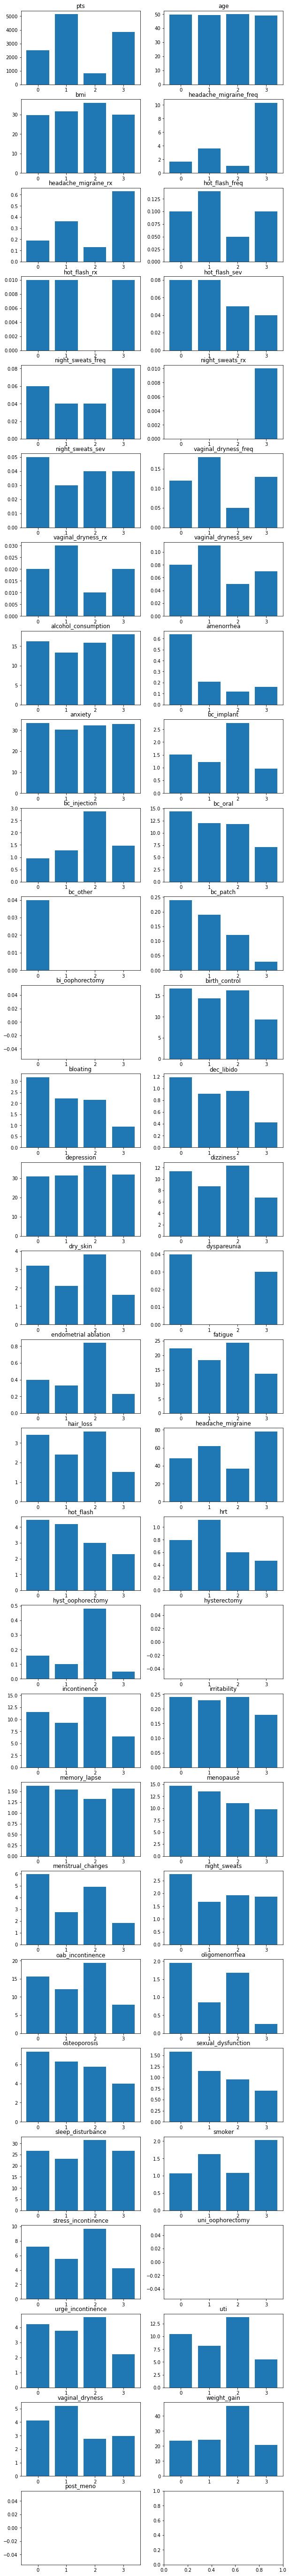

In [90]:
#Cluster Analysis in Graphs with all the features
j, k = 0,0
fig,ax = plt.subplots(29,2,figsize=(10,100))

for i in cluster_analysis_df1.columns:
    x = range(0,4)
    y = cluster_analysis_df1[i]
    ax[j,k].bar(x,y)
    ax[j,k].set_title(i, fontsize=12)
    #ax[j,k].set(xlabel = 'Cluster')
    k+=1   
    if(k==2):
        j+=1
        k=0
        
plt.show()
fig.tight_layout()



# Method: LEASPY

In [353]:
e.columns

Index(['id', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'id.1', 'quarter', 'interaction_id', 'rec_date',
       'age', 'age_grp', 'race', 'state', 'alcohol_consumption', 'amenorrhea',
       'anxiety', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other',
       'bc_patch', 'bi_oophorectomy', 'birth_control', 'bloating',
       'breast_cancer', 'cancer', 'dec_libido', 'depression', 'dizziness',
       'dry_skin', 'dyspareunia', 'endometrial ablation', 'fatigue',
       'hair_loss', 'headache_migraine', 'headache_migraine_freq',
       'headache_migraine_rx', 'hot_flash', 'hot_flash_freq', 'hot_flash_rx',
       'hot_flash_sev', 'hrt', 'hyst_oophorectomy', 'hysterectomy',
       'incontinence', 'irritability', 'last_period', 'memory_lapse',
       'menopause', 'menstrual_changes', 'night_sweats', 'night_sweats_freq',
       'night_sweats_rx', 'night_sweats_sev', 'oab_incontinence',
       'oligomenorrhea', 'osteoporosis', 'sexual_dysfunction'

In [390]:
# https://medium.com/@igoroa/analysis-of-longitudinal-data-made-easy-with-leaspy-f8d529fcb5f8
# https://gitlab.com/icm-institute/aramislab/leaspy

from leaspy import AlgorithmSettings, Data, Leaspy, IndividualParameters, __watermark__
from leaspy.datasets import Loader

e=pd.read_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\data\emr\test\df_quarter_agg3_bmi.csv")
e=e.fillna(0)
symp_list=list(e.columns)
unwanted = {'min_last_period_date', 'quarter', 
            'Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 0.1', 
            'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'id.1',
            'rec_date', 'age_grp', 'state', 'last_period', 'max'}
cofactor_list=['race', 'breast_cancer','cancer','alcohol_consumption', 
               'bc_implant', 'bc_injection', 'bc_oral', 'bc_other','bc_patch', 
               'bi_oophorectomy', 'birth_control', 'endometrial ablation',
               'hrt', 'hyst_oophorectomy', 'hysterectomy',
               'menopause', 'smoker','uni_oophorectomy', 'bmi']

symp_list = [e for e in symp_list if e not in unwanted]
symp_list = [e for e in symp_list if e not in cofactor_list]

train=e[symp_list]
cofactors=e[cofactor_list+['id', 'age']]

# Filter patients with surgical menopause, cancer
w1=e[e['bi_oophorectomy']==1]
w2=e[e['hysterectomy']==1]
w3=e[e['uni_oophorectomy']==1]
w4=e[(e['cancer']==1) | (e['breast_cancer']==1)]
w5 = pd.concat([w1,w2,w3, w4],ignore_index=True)

train=train[~train.id.isin(w5['id'])]

# Reduce sparsity in data
train['sym_count']=train.drop(['id','age'],axis=1).sum(1)
train = train[train['sym_count']>3]

# Data Prep
df1=train.copy()

# Change column names and move to front
df1.insert(0, 'TIME', df1.pop('age'))
df1.insert(0, 'ID', df1.pop('id'))
df1.columns.tolist()

cofactors.insert(0, 'TIME', cofactors.pop('age'))
cofactors.insert(0, 'ID', cofactors.pop('id'))

# Make df distinct by id and time
df1=df1.groupby(['ID', 'TIME']).first().reset_index()
cofactors=cofactors.groupby(['ID', 'TIME']).first().reset_index()

# Keep certain features
features=list(df1.columns)
features = [e for e in features if e not in ('interaction_id')]
df1 = df1[features]

# Set index
df1 = df1.set_index(['ID', 'TIME'])
cofactors = cofactors.set_index(['ID', 'TIME'])


In [380]:
data = Data.from_dataframe(df1)

algo_settings = AlgorithmSettings('mcmc_saem', 
                                  n_iter=10,         
                                  progress_bar=True) 

leaspy = Leaspy("logistic", 
                source_dimension=2, # Optional
                noise_model='gaussian_diagonal', # Optional: To get a noise estimate per feature keep it this way (default)
                )

leaspy.fit(data, settings=algo_settings)

noise = leaspy.model.parameters['noise_std']
features = leaspy.model.features

print('Standard deviation of the residual noise for feature:')
for n, f in zip(noise, features):
    print(f'- {f}: {n:.2%}')
    
 # —— Get the average individual parameters
mean_xi = leaspy.model.parameters['xi_mean'].numpy()
mean_tau = leaspy.model.parameters['tau_mean'].numpy()
mean_source = leaspy.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)

|##########|   10/10 iterations
Fit with `mcmc_saem` took: 1m 10s
The standard deviation of the noise at the end of the fit is:
amenorrhea: 39.81%
anxiety: 46.42%
bloating: 26.66%
dec_libido: 39.16%
depression: 46.27%
dizziness: 30.34%
dry_skin: 26.23%
dyspareunia: 39.87%
fatigue: 39.97%
hair_loss: 26.74%
headache_migraine: 50.49%
headache_migraine_freq: 714.41%
headache_migraine_rx: 48.93%
hot_flash: 26.80%
hot_flash_freq: 89.97%
hot_flash_rx: 28.64%
hot_flash_sev: 54.30%
incontinence: 32.10%
irritability: 40.50%
memory_lapse: 31.15%
menstrual_changes: 25.31%
night_sweats: 27.42%
night_sweats_freq: 51.35%
night_sweats_rx: 40.49%
night_sweats_sev: 35.81%
oab_incontinence: 35.37%
oligomenorrhea: 40.27%
osteoporosis: 27.78%
sexual_dysfunction: 34.67%
sleep_disturbance: 41.66%
stress_incontinence: 26.82%
urge_incontinence: 24.81%
uti: 30.27%
vaginal_dryness: 27.52%
vaginal_dryness_freq: 89.02%
vaginal_dryness_rx: 24.66%
vaginal_dryness_sev: 58.54%
weight_gain: 43.75%
post_meno: 46.87%
sym

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

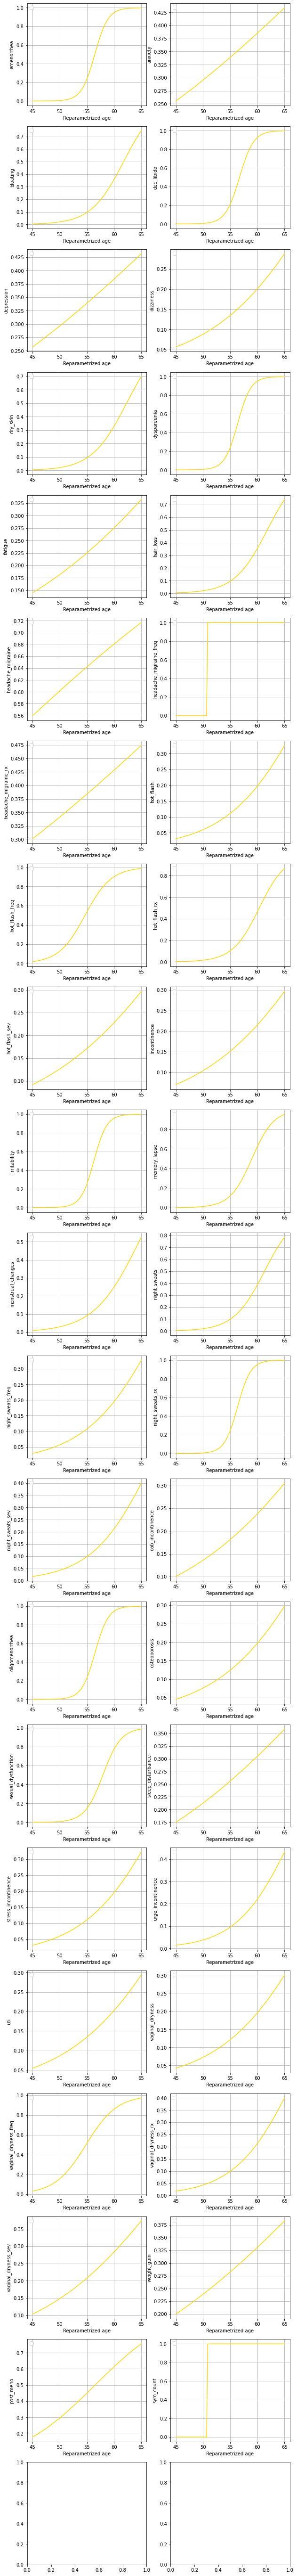

In [381]:
timepoints = np.linspace(45, 65, 100)
values = leaspy.estimate({'average': timepoints}, ip_average)
xlabel='Reparametrized age'
q=zip(leaspy.model.features, values['average'].T)
i=0

j, k = 0,0
fig,ax = plt.subplots(int((len(leaspy.model.features)/2)+1),2,figsize=(10,100))

for i in range(len(leaspy.model.features)):
    ylabel=leaspy.model.features[i]
    y_values=values['average'].T[i]
    
    ax[j,k].plot(timepoints, y_values, color="gold")
    ax[j,k].set(xlabel = xlabel, ylabel = ylabel)
    ax[j,k].grid()
    ax[j,k].legend()
    k+=1   
    if(k==2):
        j+=1
        k=0
        
plt.show()
fig.tight_layout()


In [382]:
# Personalize
personalize_settings = AlgorithmSettings('scipy_minimize', seed=0)
individual_parameters = leaspy.personalize(data, personalize_settings)

 ==> Setting seed to 0
|##################################################|   5050/5089 subjects
Personalize with `scipy_minimize` took: 1m 3s
The standard deviation of the noise at the end of the personalize is:
amenorrhea: 6.67%
anxiety: 45.51%
bloating: 15.82%
dec_libido: 10.03%
depression: 45.61%
dizziness: 29.22%
dry_skin: 16.34%
dyspareunia: 4.93%
fatigue: 39.16%
hair_loss: 15.86%
headache_migraine: 50.49%
headache_migraine_freq: 723.96%
headache_migraine_rx: 48.75%
hot_flash: 24.32%
hot_flash_freq: 79.98%
hot_flash_rx: 13.78%
hot_flash_sev: 53.29%
incontinence: 30.67%
irritability: 6.87%
memory_lapse: 12.71%
menstrual_changes: 18.40%
night_sweats: 15.18%
night_sweats_freq: 49.87%
night_sweats_rx: 8.34%
night_sweats_sev: 32.75%
oab_incontinence: 34.22%
oligomenorrhea: 10.20%
osteoporosis: 27.00%
sexual_dysfunction: 11.55%
sleep_disturbance: 41.01%
stress_incontinence: 24.43%
urge_incontinence: 20.13%
uti: 28.81%
vaginal_dryness: 25.73%
vaginal_dryness_freq: 80.16%
vaginal_dryness

Seen ages: [41 42 44 45]
{'xi': 0.09385804086923599, 'tau': 51.84543991088867, 'sources': [0.033267535269260406, -0.0762924998998642]}


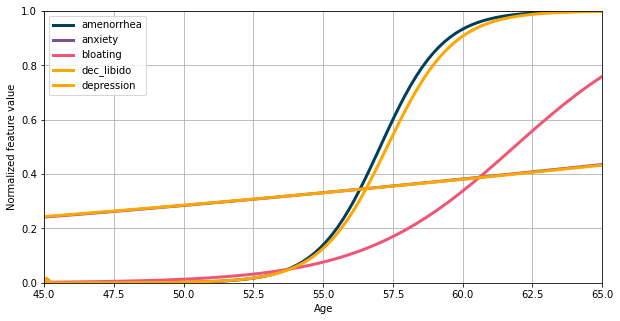

In [383]:
subject_id = 612293
observations = df1.loc[subject_id]
print(f'Seen ages: {observations.index.values}')
print(individual_parameters[str(subject_id)])

timepoints = np.linspace(45, 65, 100)
reconstruction = leaspy.estimate({str(subject_id): timepoints}, individual_parameters)

plot_trajectory(timepoints, reconstruction[str(subject_id)], observations, xlabel='Age')

['race', 'breast_cancer', 'cancer', 'alcohol_consumption', 'bc_implant', 'bc_injection', 'bc_oral', 'bc_other', 'bc_patch', 'bi_oophorectomy', 'birth_control', 'endometrial ablation', 'hrt', 'hyst_oophorectomy', 'hysterectomy', 'menopause', 'smoker', 'uni_oophorectomy', 'bmi']
menopause


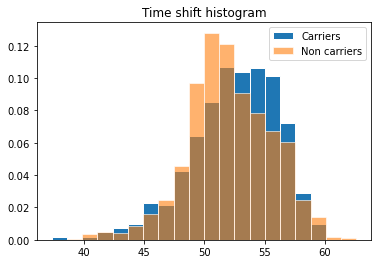

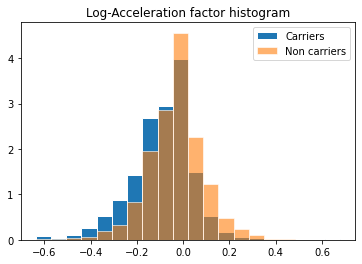

Ttest_indResult(statistic=5.07288589723848, pvalue=3.946184727421629e-07)
Ttest_indResult(statistic=-21.332657567976725, pvalue=4.378387625094335e-100)
MannwhitneyuResult(statistic=25838929.0, pvalue=6.54116370880346e-13)
MannwhitneyuResult(statistic=17389325.5, pvalue=1.6077423041283814e-86)


In [402]:
# —— Convert individual parameters to dataframe
df_ip = individual_parameters.to_dataframe().reset_index()
df_ip['ID']=pd.to_numeric(df_ip['ID'])

# —— Merge with cofactors
print(cofactor_list)
cofactor_var=cofactor_list[15]
print(cofactor_var)
cofactor = cofactors[[cofactor_var]]
cofactor=cofactor.reset_index()
df_ip = df_ip.merge(cofactor, on='ID').reset_index()

# —— Separate the individual parameters with respect to the cofactor
carriers = df_ip[df_ip[cofactor_var] == 1.]
non_carriers = df_ip[df_ip[cofactor_var] == 0.]

def plot_histo(title, ft, bins_nb=20):
    
    # compute bins (same for 2 carriers & non-carriers)
    _, bins = np.histogram(df_ip[ft], bins=bins_nb)
    
    plt.title(title)
    plt.hist(carriers[ft], density=True, bins=bins, edgecolor='white', label='Carriers')
    plt.hist(non_carriers[ft], density=True, bins=bins, alpha=0.6, edgecolor='white', label='Non carriers')
    plt.legend()
    plt.show()

# —— Plot the time shifts in carriers and non-carriers
plot_histo('Time shift histogram', 'tau')

# —— Plot the acceleration factor in carriers and non-carriers
plot_histo('Log-Acceleration factor histogram', 'xi')

from scipy import stats

# —— Student t-test (under the asumption of a gaussian distribution only)
print(stats.ttest_ind(carriers['tau'], non_carriers['tau']))
print(stats.ttest_ind(carriers['xi'], non_carriers['xi']))

# —— Mann-withney t-test
print(stats.mannwhitneyu(carriers['tau'], non_carriers['tau']))
print(stats.mannwhitneyu(carriers['xi'], non_carriers['xi']))

In [ ]:
# Predict/simulate trajectory based on inputs


# Method ACTPC

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import random
import os, sys

from tensorflow.python.ops.rnn import _transpose_batch_time
from sklearn.model_selection import train_test_split

#performance metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

os.chdir(r"C:\Users\A4023862\Documents\GitHub")
from path_segmentation.functions_actpc import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_lst[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  1,  0,  1,  4,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 21],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  1,  0,  1,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 18],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  1,  5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 23],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 21],
    

In [116]:
patients = data_lst.shape[0]
t_series = data_lst.shape[1]
features = data_lst.shape[2]


K = 6

h_dim_FC   = 50 #for fully_connected layers
h_dim_RNN  = 50

x_dim = np.shape(data_x)[2]
y_dim = np.shape(data_y)[2]
  
    
num_layer_encoder    = 1
num_layer_selector   = 2
num_layer_predictor  = 2

z_dim = h_dim_RNN * num_layer_encoder

max_length = np.shape(data_x)[1]

rnn_type          = 'LSTM' #GRU, LSTM


input_dims ={
    'x_dim': x_dim,
    'y_dim': y_dim,
    'y_type': y_type,
    'max_cluster': K,
    'max_length': max_length    
}

network_settings ={
    'h_dim_encoder': h_dim_RNN,
    'num_layers_encoder': num_layer_encoder,
    'rnn_type': rnn_type,
    'rnn_activate_fn': tf.nn.tanh,

    'h_dim_selector': h_dim_FC,
    'num_layers_selector': num_layer_selector,
    
    'h_dim_predictor': h_dim_FC,
    'num_layers_predictor': num_layer_predictor,
    
    'fc_activate_fn': tf.nn.relu
}

NameError: name 'data_x' is not defined